In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
## Regression
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE
## Classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix


In [2]:

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-06-13 23:20:56.175027: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2023-06-13 23:20:56.203481: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2100000000 Hz
2023-06-13 23:20:56.211985: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559026f9d060 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-13 23:20:56.212040: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-13 23:20:56.218395: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-13 23:20:58.106994: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559026880430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-13 23:20:58.107052: 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9197326414399691303,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7248805276375716865
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16983345708476013999
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8238321824976034297
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1073161779348496016
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5930727730827707626
 physical_device_desc: "device: XLA_GPU device",
 

_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:20:58.279041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:20:58.281655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:20:58.284280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 3 with properties: 
pciBusID: 0000:1e:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz core

In [3]:
device_name = tf.test.gpu_device_name()
if len(device_name)>0:
    print(f'GPU has been found... device name is{device_name}')
else:
    print('No GPU has been found...')

GPU has been found... device name is/device:GPU:0


2023-06-13 23:20:58.595405: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:20:58.601334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:20:58.603945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:20:58.606517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 3 with properties: 
pciBusID: 0000:1e:00.0 name: Quadro RTX

In [4]:
#load data(sometimes need to use "/")
df = pd.read_csv('DATA/AMD.csv')
# Colab
#df = pd.read_csv('')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-05-19,0.000000,2.708333,2.666667,2.687500,2.687500,66000
1,1980-05-20,0.000000,2.750000,2.677083,2.750000,2.750000,453600
2,1980-05-21,0.000000,2.802083,2.739583,2.781250,2.781250,512400
3,1980-05-22,0.000000,2.916667,2.812500,2.916667,2.916667,499200
4,1980-05-23,0.000000,2.989583,2.895833,2.989583,2.989583,411600
...,...,...,...,...,...,...,...
10845,2023-05-24,105.980003,108.910004,105.639999,108.269997,108.269997,65910500
10846,2023-05-25,117.309998,120.690002,115.800003,120.349998,120.349998,108514700
10847,2023-05-26,122.459999,127.430000,120.889999,127.029999,127.029999,92812000
10848,2023-05-30,130.419998,130.789993,123.510002,125.269997,125.269997,98902300


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [5]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10850 non-null  object 
 1   Open       10850 non-null  float64
 2   High       10850 non-null  float64
 3   Low        10850 non-null  float64
 4   Close      10850 non-null  float64
 5   Adj Close  10850 non-null  float64
 6   Volume     10850 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 593.5+ KB


In [6]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,1980-05-19,2.687500
1,1980-05-20,2.750000
2,1980-05-21,2.781250
3,1980-05-22,2.916667
4,1980-05-23,2.989583


In [7]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Close
count,10850.000000
mean,16.956992
std,22.652365
min,1.620000
25%,5.354167
50%,9.875000
75%,16.062500
max,161.910004


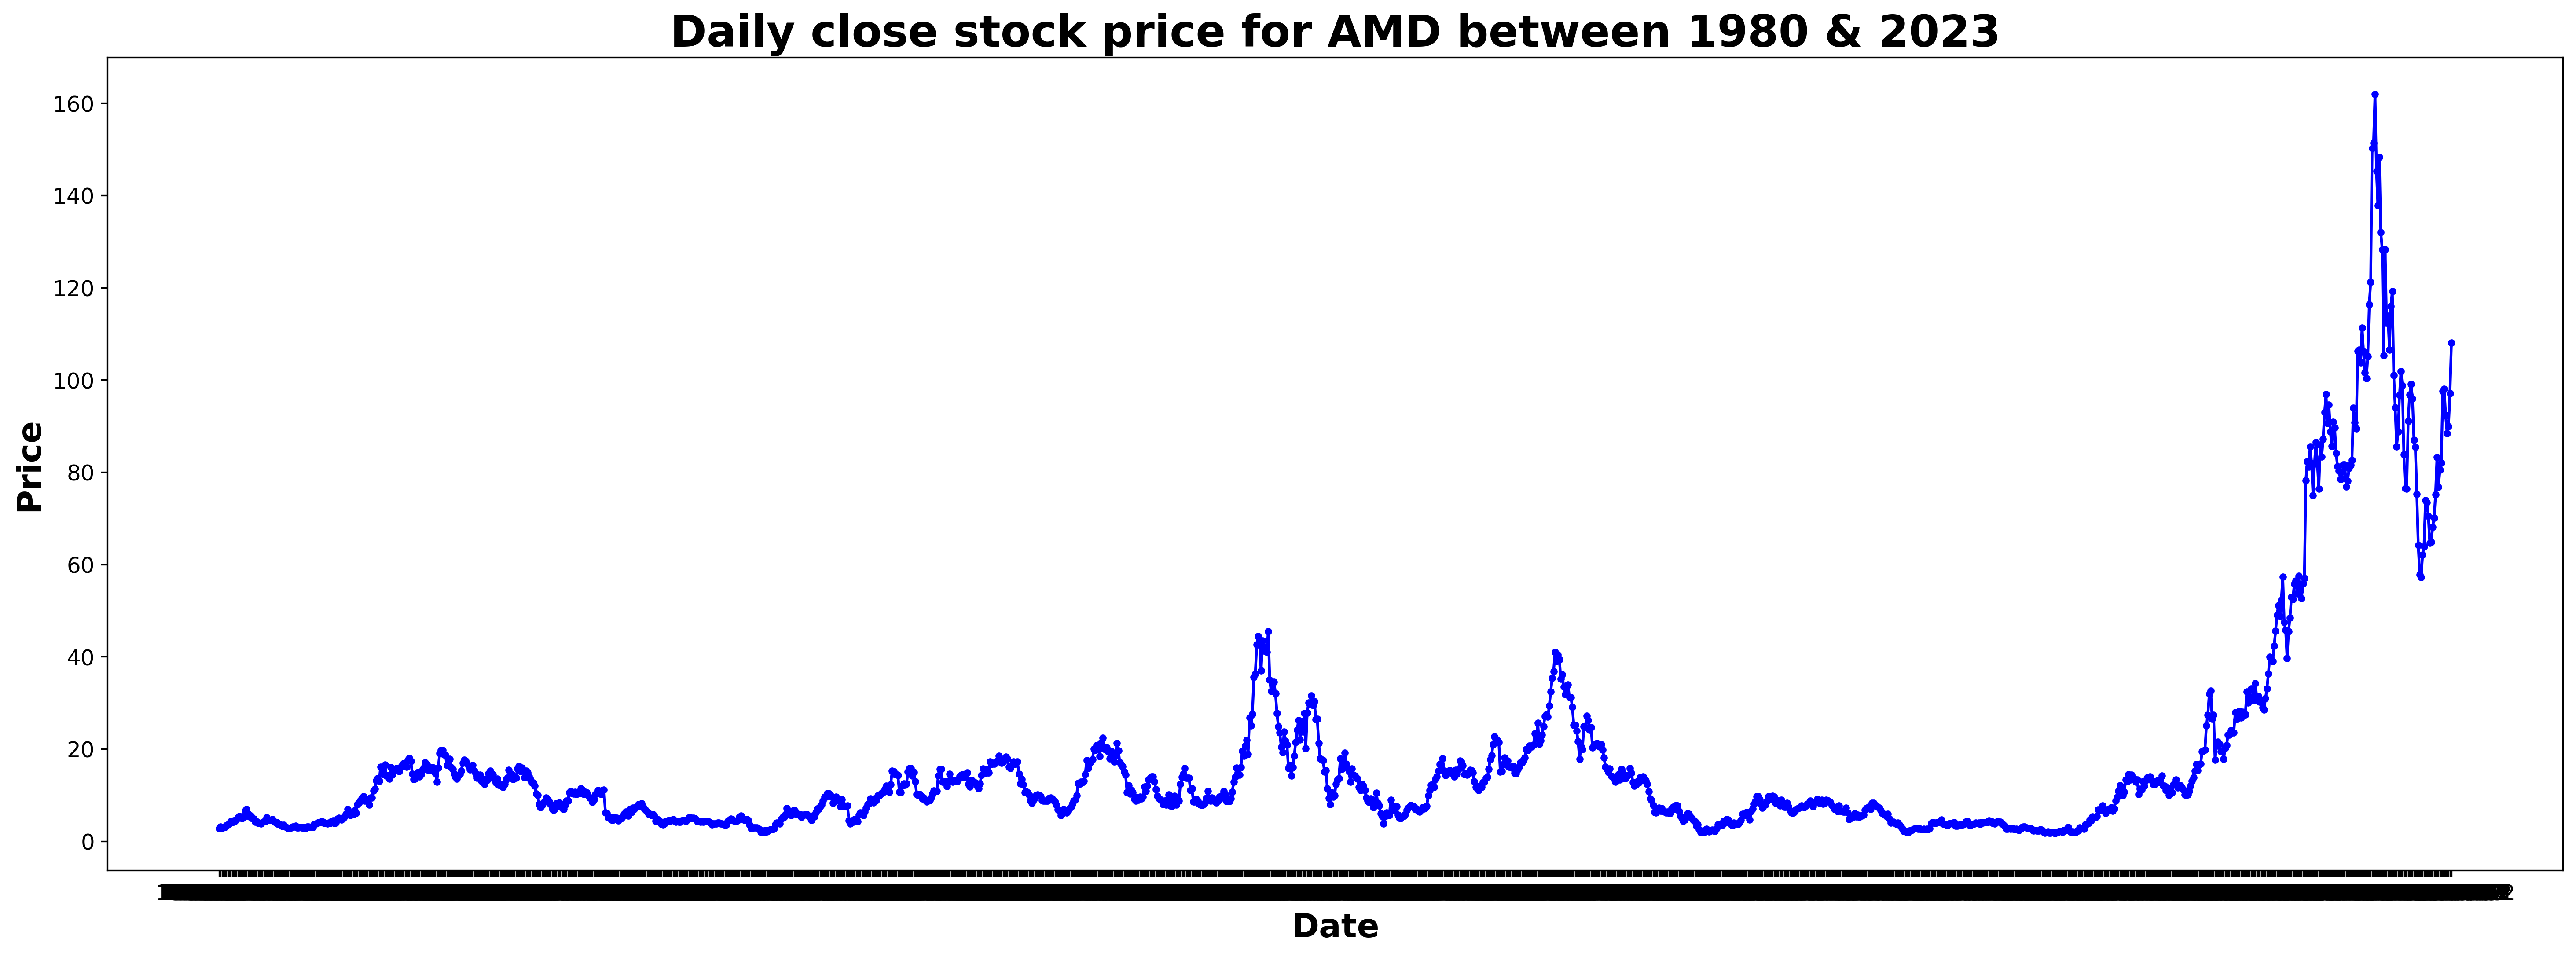

In [8]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Daily close stock price for AMD between 1980 & 2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Price',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'][::7],new_df['Close'][::7],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [9]:
# Add three new column for fall or rise or no change
new_df['Fall']=np.where(new_df['Close']<new_df['Close'].shift(1),1,0)
new_df['Rise']=np.where(new_df['Close']>new_df['Close'].shift(1),1,0)
new_df['No_Change']=np.where(new_df['Close']==new_df['Close'].shift(1),1,0)

# Create N lags
N = 20
lags=["Lag_"+str(i) for i in range(1,N+1)]
for lag in lags:
    new_df[lag]=new_df['Close'].shift(int(lag[4:]))

new_df.head(10)

,Date,Close,Fall,Rise,No_Change,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,...,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
0,1980-05-19,2.687500,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-05-20,2.750000,0,1,0,2.687500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-05-21,2.781250,0,1,0,2.750000,2.687500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1980-05-22,2.916667,0,1,0,2.781250,2.750000,2.687500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980-05-23,2.989583,0,1,0,2.916667,2.781250,2.750000,2.687500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1980-05-27,3.010417,0,1,0,2.989583,2.916667,2.781250,2.750000,2.687500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1980-05-28,3.145833,0,1,0,3.010417,2.989583,2.916667,2.781250,2.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1980-05-29,3.083333,1,0,0,3.145833,3.010417,2.989583,2.916667,2.781250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1980-05-30,3.166667,0,1,0,3.083333,3.145833,3.010417,2.989583,2.916667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1980-06-02,3.104167,1,0,0,3.166667,3.083333,3.145833,3.010417,2.989583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Drop out missing values and rest index
dummied_df=new_df.dropna(axis=0, how='any').copy()
dummied_df=dummied_df.reset_index(drop=True)
dummied_df

,Date,Close,Fall,Rise,No_Change,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,...,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
0,1980-06-17,3.062500,0,1,0,3.031250,3.093750,3.093750,3.052083,2.968750,...,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500
1,1980-06-18,3.020833,1,0,0,3.062500,3.031250,3.093750,3.093750,3.052083,...,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000
2,1980-06-19,2.968750,1,0,0,3.020833,3.062500,3.031250,3.093750,3.093750,...,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250
3,1980-06-20,2.927083,1,0,0,2.968750,3.020833,3.062500,3.031250,3.093750,...,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667
4,1980-06-23,2.937500,0,1,0,2.927083,2.968750,3.020833,3.062500,3.031250,...,3.000000,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10825,2023-05-24,108.269997,0,1,0,108.120003,108.000000,105.820000,107.930000,103.750000,...,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003,87.440002,85.940002
10826,2023-05-25,120.349998,0,1,0,108.269997,108.120003,108.000000,105.820000,107.930000,...,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003,87.440002
10827,2023-05-26,127.029999,0,1,0,120.349998,108.269997,108.120003,108.000000,105.820000,...,97.099998,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003
10828,2023-05-30,125.269997,1,0,0,127.029999,120.349998,108.269997,108.120003,108.000000,...,95.260002,97.099998,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002


In [11]:
# Convert Y into dummies
Y=dummied_df.iloc[:,[2,3,4]].copy()
dummied_Y=Y.to_numpy()
dummied_Y

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

# 3. Data preprocessing under time-series structure

In [12]:
split_point = int(len(dummied_df)*0.8)

A total of 43 years are in the data set. In this practice, we will use the last nine years of data as the testing set

In [13]:
# Train data
Forecast_train_data=dummied_df.iloc[0:split_point,:].copy()
Forecast_train_data

,Date,Close,Fall,Rise,No_Change,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,...,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
0,1980-06-17,3.062500,0,1,0,3.031250,3.093750,3.093750,3.052083,2.968750,...,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500
1,1980-06-18,3.020833,1,0,0,3.062500,3.031250,3.093750,3.093750,3.052083,...,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000
2,1980-06-19,2.968750,1,0,0,3.020833,3.062500,3.031250,3.093750,3.093750,...,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250
3,1980-06-20,2.927083,1,0,0,2.968750,3.020833,3.062500,3.031250,3.093750,...,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667
4,1980-06-23,2.937500,0,1,0,2.927083,2.968750,3.020833,3.062500,3.031250,...,3.000000,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8659,2014-10-15,2.610000,1,0,0,2.620000,2.740000,2.720000,2.950000,3.280000,...,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000,3.880000,3.820000
8660,2014-10-16,2.640000,0,1,0,2.610000,2.620000,2.740000,2.720000,2.950000,...,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000,3.880000
8661,2014-10-17,2.720000,0,1,0,2.640000,2.610000,2.620000,2.740000,2.720000,...,3.390000,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000
8662,2014-10-20,2.670000,1,0,0,2.720000,2.640000,2.610000,2.620000,2.740000,...,3.400000,3.390000,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000


In [14]:
# Test data
Forecast_test_data=dummied_df.iloc[split_point:,:].copy()
# Forecast_train_data=dummied_df.iloc[0:213,:].copy()
Forecast_test_data

,Date,Close,Fall,Rise,No_Change,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,...,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
8664,2014-10-22,2.640000,1,0,0,2.770000,2.670000,2.720000,2.640000,2.610000,...,3.280000,3.360000,3.400000,3.390000,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000
8665,2014-10-23,2.690000,0,1,0,2.640000,2.770000,2.670000,2.720000,2.640000,...,3.280000,3.280000,3.360000,3.400000,3.390000,3.350000,3.410000,3.550000,3.600000,3.630000
8666,2014-10-24,2.680000,1,0,0,2.690000,2.640000,2.770000,2.670000,2.720000,...,2.950000,3.280000,3.280000,3.360000,3.400000,3.390000,3.350000,3.410000,3.550000,3.600000
8667,2014-10-27,2.660000,1,0,0,2.680000,2.690000,2.640000,2.770000,2.670000,...,2.720000,2.950000,3.280000,3.280000,3.360000,3.400000,3.390000,3.350000,3.410000,3.550000
8668,2014-10-28,2.720000,0,1,0,2.660000,2.680000,2.690000,2.640000,2.770000,...,2.740000,2.720000,2.950000,3.280000,3.280000,3.360000,3.400000,3.390000,3.350000,3.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10825,2023-05-24,108.269997,0,1,0,108.120003,108.000000,105.820000,107.930000,103.750000,...,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003,87.440002,85.940002
10826,2023-05-25,120.349998,0,1,0,108.269997,108.120003,108.000000,105.820000,107.930000,...,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003,87.440002
10827,2023-05-26,127.029999,0,1,0,120.349998,108.269997,108.120003,108.000000,105.820000,...,97.099998,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003
10828,2023-05-30,125.269997,1,0,0,127.029999,120.349998,108.269997,108.120003,108.000000,...,95.260002,97.099998,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002


# 5. Set dependent variable(Y or target) & independent variable(X) 

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

In [15]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close','Fall','Rise','No_Change'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data[['Fall','Rise','No_Change']].copy()

# 6. Creating Net 

# Sequential style coding for creating net

Note: The following code demonstrate the most common style for creating net

In [16]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [17]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=40, input_dim=len(lags), activation='relu'))

# Add 10 dense layers
dense_generator(Fmodel,4,40)

# Add dropout layer
Fmodel.add(Dropout(rate=0.2))

# Add regularization layer optional
#model.add(BatchNormalization())

# Add output layer
Fmodel.add(Dense(units=3, activation='softmax'))

# Compile the defined Net
# opt=SGD(learning_rate=0.001,momentum=0.5)
# opt=Adam(learning_rate=0.002,beta_1=0.95)
opt=Adam(learning_rate=0.001,beta_1=0.9)
Fmodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Finally check the model 
Fmodel.summary()

2023-06-13 23:21:08.208116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:21:08.215246: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:21:08.221702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-06-13 23:21:08.230436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 3 with properties: 
pciBusID: 0000:1e:00.0 name: Quadro RTX

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_2 (Dense)              (None, 160)               12960     
_________________________________________________________________
dense_3 (Dense)              (None, 320)               51520     
_________________________________________________________________
dense_4 (Dense)              (None, 640)               205440    
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1

# 7. Fit the Fmodel (train/validation)

In [18]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=500, batch_size=64,verbose=1,validation_split=0.2)

Epoch 1/500


2023-06-13 23:21:10.494767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


109/109 [==============================] - 1s 7ms/step - loss: 0.9744 - accuracy: 0.4672 - val_loss: 0.8899 - val_accuracy: 0.4807
Epoch 2/500
109/109 [==============================] - 1s 5ms/step - loss: 0.8939 - accuracy: 0.4667 - val_loss: 0.8847 - val_accuracy: 0.4784
Epoch 3/500
109/109 [==============================] - 1s 5ms/step - loss: 0.8919 - accuracy: 0.4653 - val_loss: 0.8494 - val_accuracy: 0.4714
Epoch 4/500
109/109 [==============================] - 1s 5ms/step - loss: 0.8933 - accuracy: 0.4797 - val_loss: 0.8859 - val_accuracy: 0.4743
Epoch 5/500
109/109 [==============================] - 1s 5ms/step - loss: 0.8911 - accuracy: 0.4712 - val_loss: 0.8504 - val_accuracy: 0.4812
Epoch 6/500
109/109 [==============================] - 1s 5ms/step - loss: 0.8915 - accuracy: 0.4711 - val_loss: 0.8825 - val_accuracy: 0.4841
Epoch 7/500
109/109 [==============================] - 1s 5ms/step - loss: 0.8910 - accuracy: 0.4592 - val_loss: 0.8633 - val_accuracy: 0.4899
Epoch 8/500

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

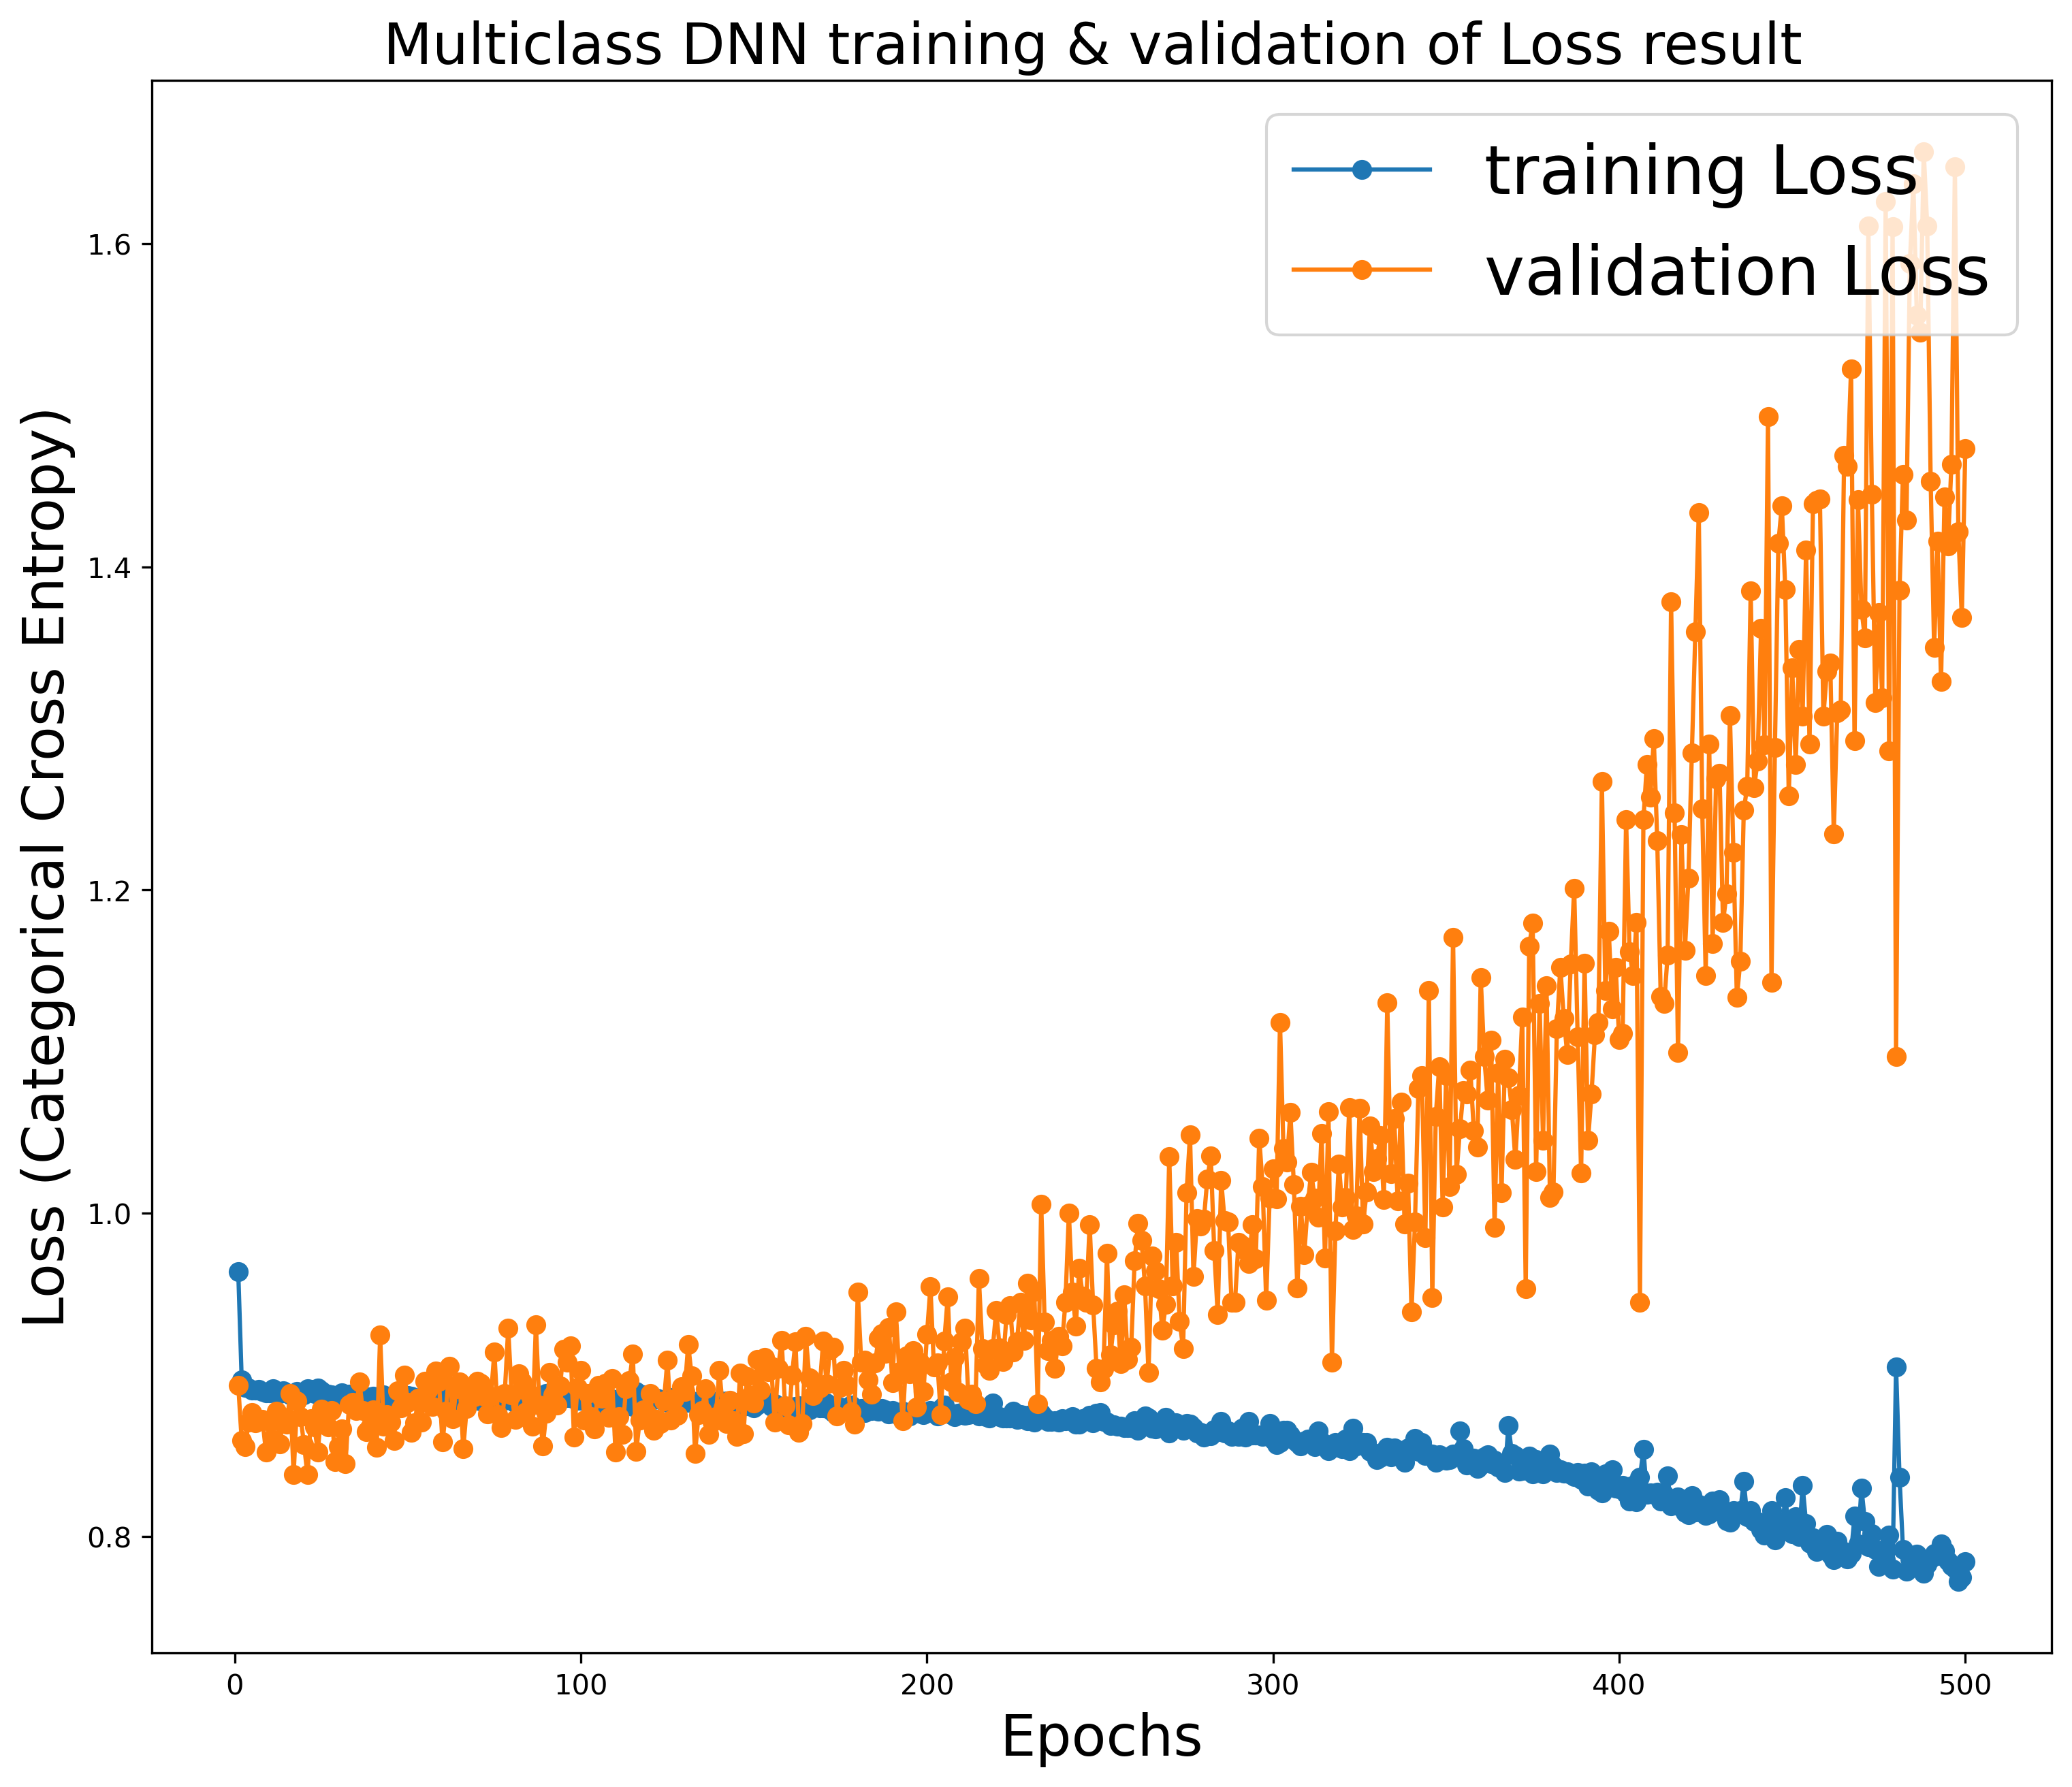

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Categorical Cross Entropy)',fontsize=20)
plt.title('Multiclass DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

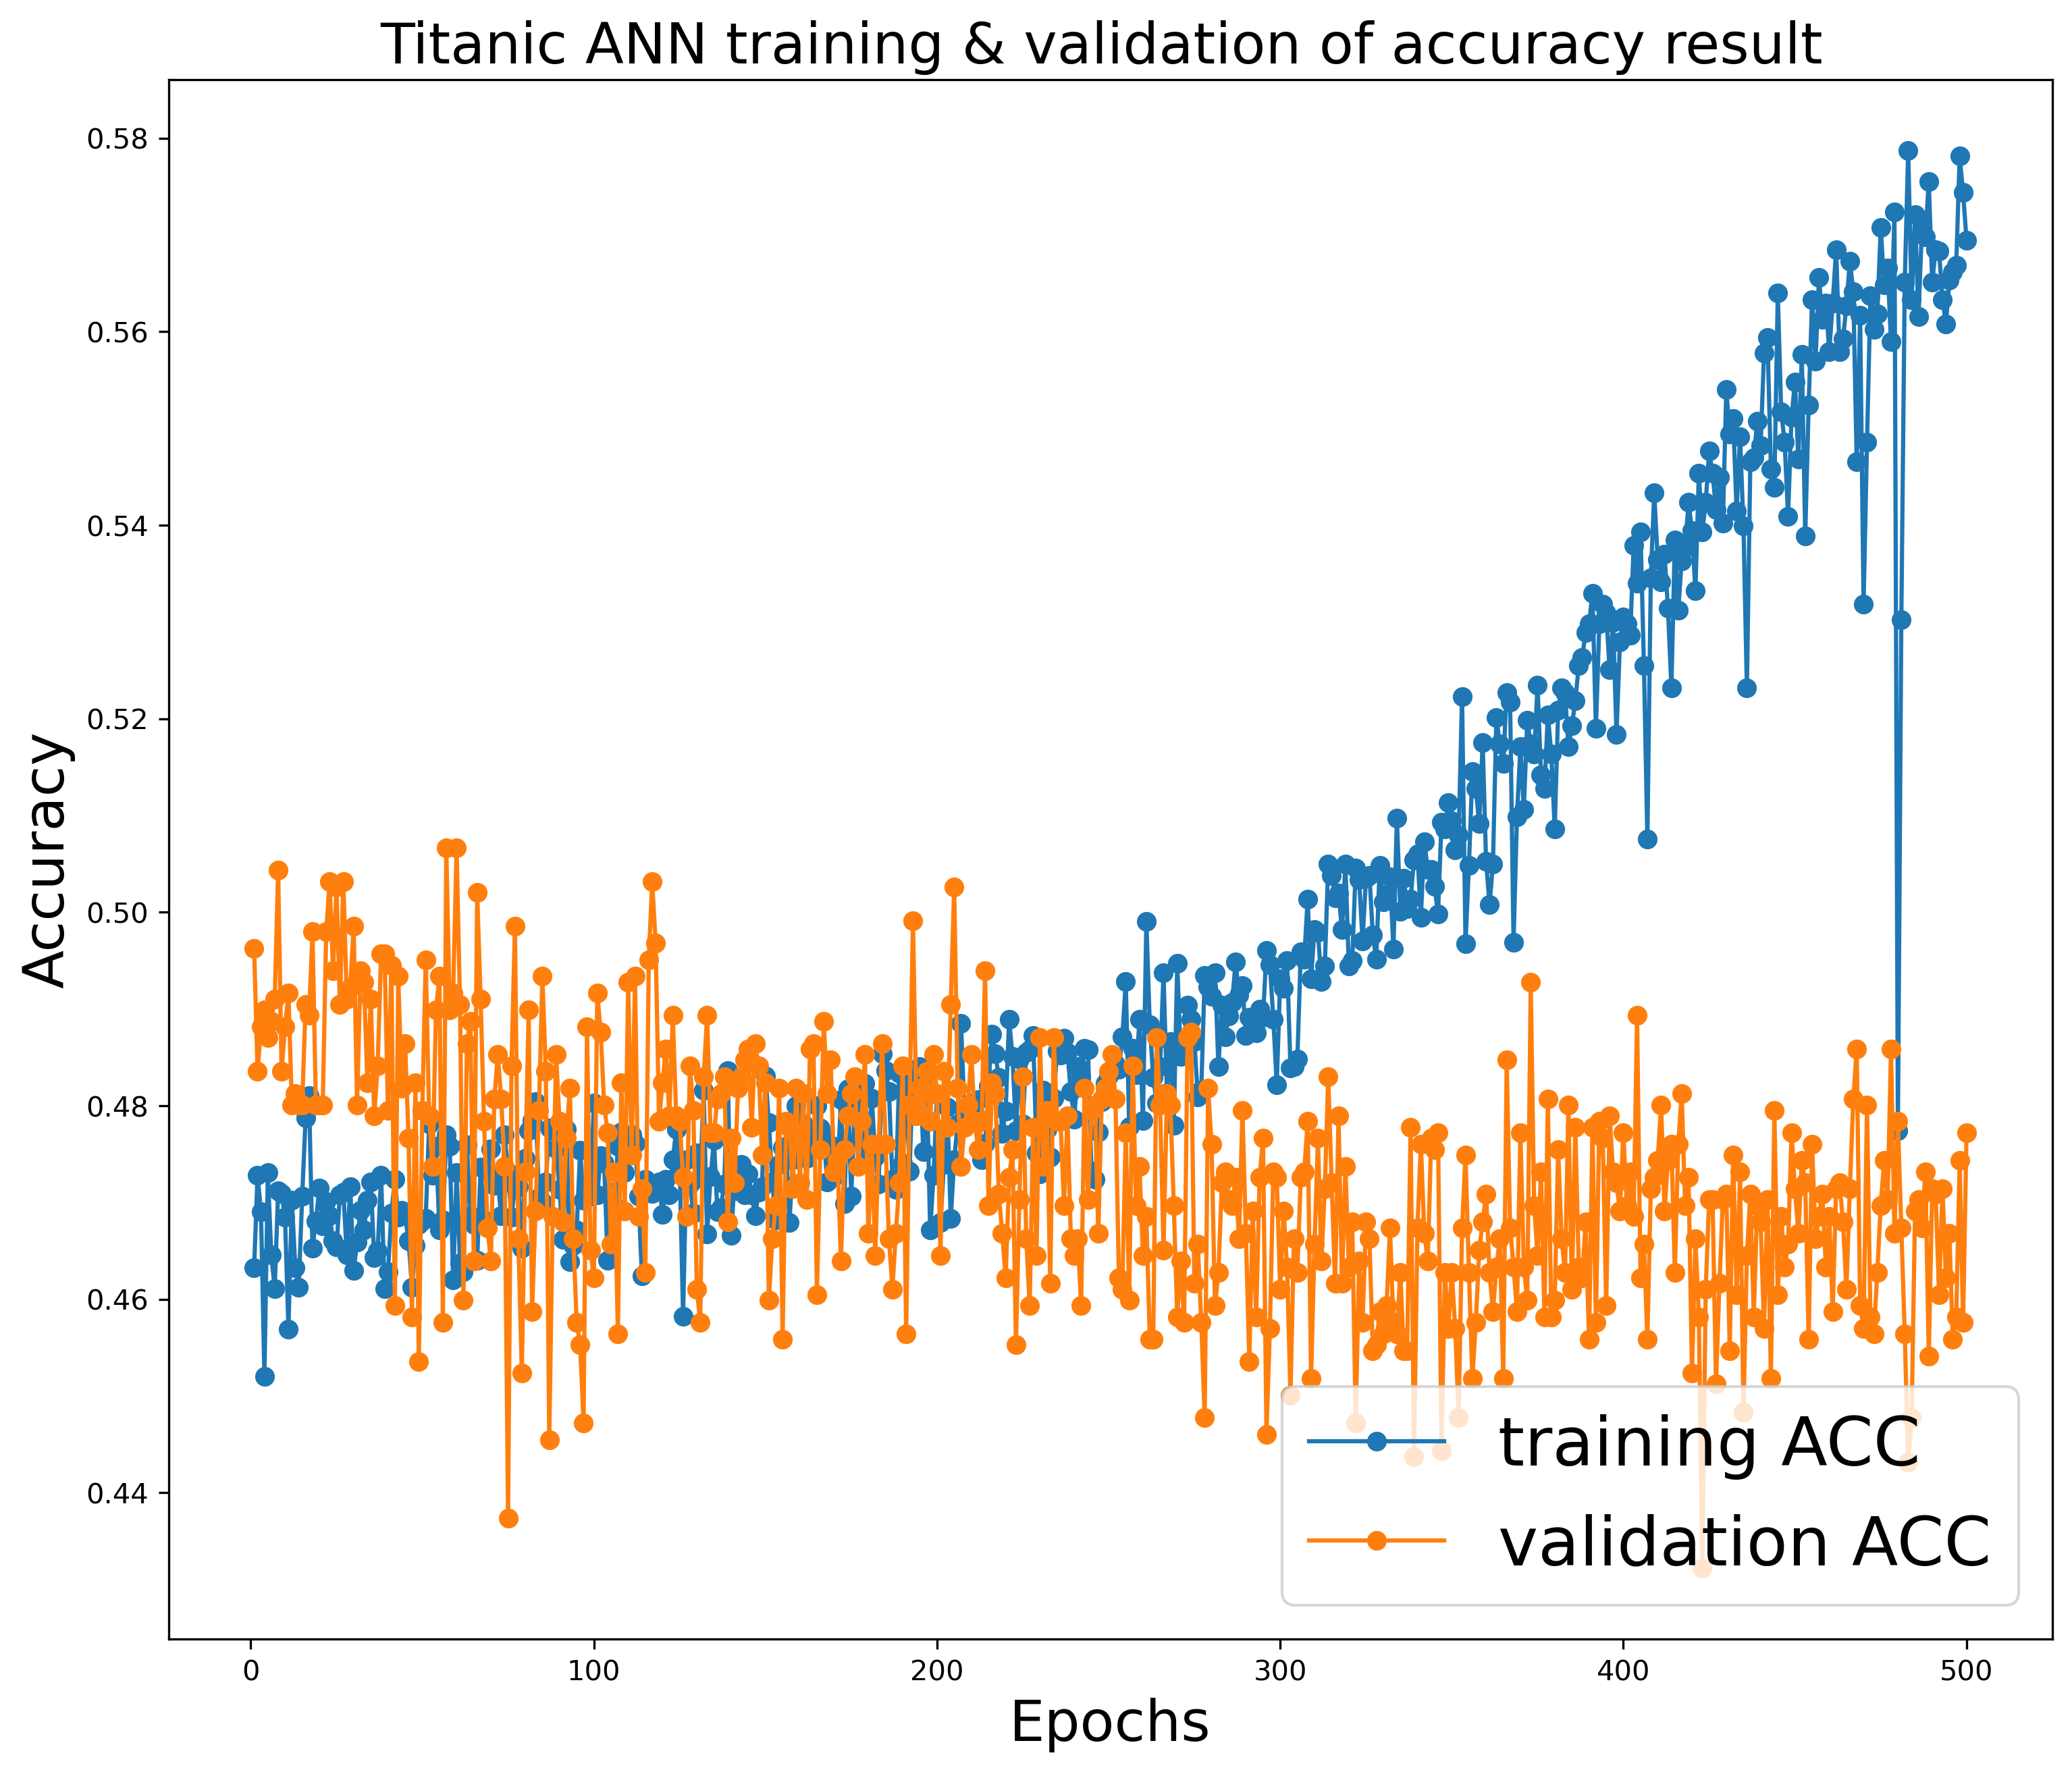

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['accuracy']
val_acc_values=modeling_result['val_accuracy']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Titanic ANN training & validation of accuracy result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='o',label='training ACC')
plt.plot(epochs, val_acc_values,marker='o',label='validation ACC')
plt.legend(loc=4,fontsize=24)
plt.show()

In [ ]:
# 7.3 Save the trained model
Fmodel.save('./Multiclass_DNN_trained_model.h5')
# Colab
#model.save('titanic_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
# 7.4 Restore the saved model for testing
ANN_model=keras.models.load_model('./Multiclass_DNN_trained_model.h5')
# Colab
#ANN_model=keras.models.load_model('')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close','Fall','Rise','No_Change'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data[['Fall','Rise','No_Change']].copy()

In [ ]:
prediction=ANN_model.predict_on_batch(x_forecast_test)
prediction

array([[9.9984014e-01, 1.5977611e-04, 4.6470805e-09],
       [9.9542856e-01, 4.5709214e-03, 5.1690330e-07],
       [9.9890161e-01, 4.8041189e-04, 6.1799580e-04],
       ...,
       [9.9998796e-01, 1.2059722e-05, 5.3003774e-10],
       [9.7901249e-01, 2.0987466e-02, 2.2534519e-10],
       [9.1670483e-01, 8.3295241e-02, 2.2620361e-10]], dtype=float32)

In [ ]:
df_prediction=pd.DataFrame(prediction)
df_prediction.columns=['Fall','Rise','No_Change']
df_prediction

,Fall,Rise,No_Change
0,0.999840,0.000160,4.647080e-09
1,0.995429,0.004571,5.169033e-07
2,0.998902,0.000480,6.179958e-04
3,0.937337,0.051691,1.097188e-02
4,0.620620,0.378924,4.556792e-04
...,...,...,...
2161,0.999813,0.000187,6.395163e-10
2162,0.999975,0.000024,3.263154e-10
2163,0.999988,0.000012,5.300377e-10
2164,0.979012,0.020987,2.253452e-10


In [ ]:
# Convert each sample final prediction according to the class with the largest likelihood
final_prediction=[]
for i in range(0,len(prediction)):
    origin=prediction[i]
    max_idx=np.argmax(origin)
    convert=np.zeros_like(origin)
    convert[max_idx]=1
    final_prediction.append(convert)

In [ ]:
df_final_prediction=pd.DataFrame(final_prediction)
df_final_prediction.columns=['Fall','Rise','No_Change']
df_final_prediction=df_final_prediction.astype(int)
df_final_prediction

,Fall,Rise,No_Change
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
2161,1,0,0
2162,1,0,0
2163,1,0,0
2164,1,0,0


In [ ]:
fpred=df_final_prediction.to_numpy()
reverted = np.argmax(fpred, axis=1)
reverted

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_test = y_forecast_test
y_test_reverted=np.argmax(y_test, axis=1)
y_test_reverted

ValueError: Shape of passed values is (2166, 1), indices imply (2166, 3)

In [ ]:
# Calculating the mertics at once
testing_acc=accuracy_score(y_test,fpred)
testing_f1s=f1_score(y_test,fpred,average=None)
testing_pre=precision_score(y_test,fpred,average=None)
testing_sen=recall_score(y_test,fpred,average=None)
testing_cm=confusion_matrix(y_test_reverted,reverted)
print('Testing result:')
print('Testing ACC:',testing_acc)
print('Testing f1s:',testing_f1s)
print('Testing pre:',testing_pre)
print('Testing sen:',testing_sen)
print('')
print('Testing confusion matrix:')
print(testing_cm)

NameError: name 'y_test' is not defined